Found 0.05 in 2024-05-31T00:16-dynamic_48_0_05.txt
Found 0.05 in 2024-05-31T02:41-dynamic_48_0_05.txt
Found 0.05 in 2024-05-31T05:06-dynamic_48_0_05.txt


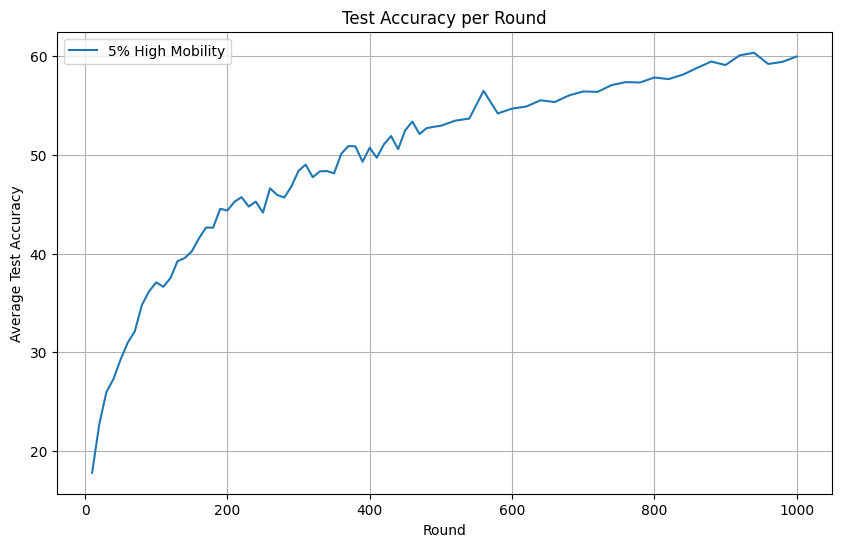

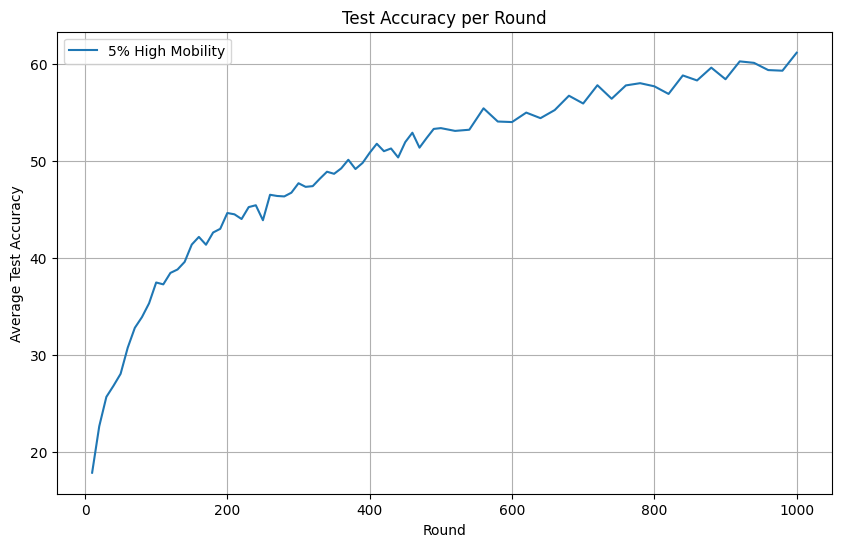

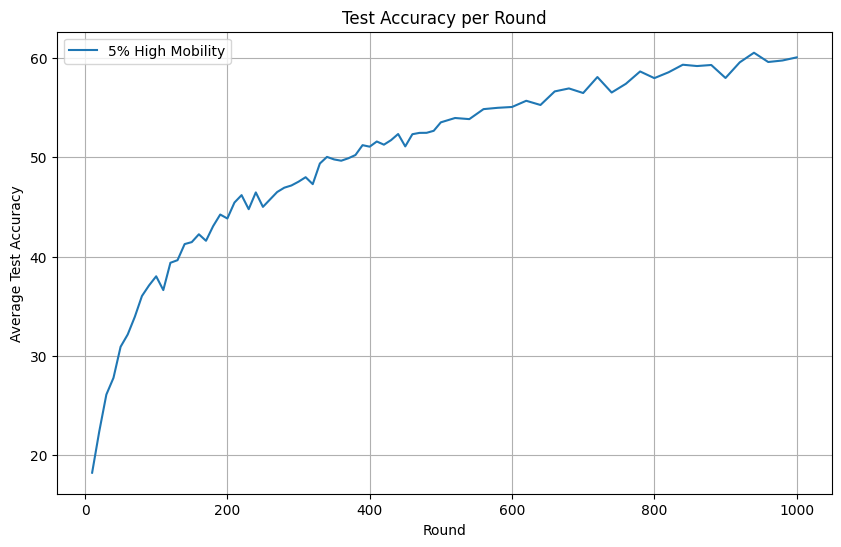

In [108]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt    
from collections import defaultdict


def average_of_first_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[:n])

def average_of_last_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[-n:])

def find_data_dir_with_mobility(base_dir: str, mobility: float):
    mobility_str = str(mobility).replace(".", "_") + ".txt"
    for dir in os.listdir(base_dir):
        if mobility_str in dir:
            print(f"Found {mobility} in {dir}")
            return os.path.join(base_dir, dir, "machine0")
    
    print(f"Could not find mobility {mobility} in {base_dir}")
    raise ValueError

def inf_dict():
    return defaultdict(inf_dict)

num_nodes = 48
experiment_groups ={
    1: ".saved_experiments/2024-05-30-new-neighbours-1",
    2: ".saved_experiments/2024-05-30-new-neighbours-2",
    3: ".saved_experiments/2024-05-30-new-neighbours-3",
}
experiments = {
    # 0.0: "0% High Mobility",
    0.05: "5% High Mobility",
    # 0.2: "20% High Mobility",
    # 0.4: "40% High Mobility",
    # 0.6: "60% High Mobility",
    # 0.8: "80% High Mobility",
    # 1.0: "100% High Mobility",
}
statistics = ["test_acc"]

def load_experiment_data(experiment_data, base_dir):
    for experiment, _ in experiments.items():
        experiment_data[experiment] = {}
        dir = find_data_dir_with_mobility(base_dir, experiment)
        for i in range(num_nodes):
            file_path = os.path.join(dir, f"{i}_results.json")
            if os.path.exists(file_path):
                with open(file_path, "r") as file:
                    content = json.load(file)

                    for statistic, rounds in content.items():
                        if statistic not in experiment_data[experiment]:
                            experiment_data[experiment][statistic] = {}

                        for round, value in rounds.items():
                            round = int(round)
                            if round not in experiment_data[experiment][statistic]:
                                experiment_data[experiment][statistic][round] = []
                            experiment_data[experiment][statistic][round].append(value)

def compute_experiment_averages(experiment_data, statistics):
    averages = inf_dict()
    high_mobility_averages = inf_dict() 
    low_mobility_averages = inf_dict()
    for experiment in experiment_data:
        averages[experiment] = inf_dict()
        for statistic in statistics:
            for round, values in experiment_data[experiment][statistic].items():
                averages[experiment][statistic][round] = np.mean(values)

                if round == "10":
                    print(values)
                    print(len(values))

                high_mobility_proportion = experiment
                low_mobility_proportion = 1 - experiment
                high_mobility_averages[experiment][statistic][round] = average_of_first_percent(values, high_mobility_proportion)
                low_mobility_averages[experiment][statistic][round] = average_of_last_percent(values, low_mobility_proportion)
    return averages, high_mobility_averages, low_mobility_averages

def plot_high_low_averages(experiment_names, averages, experiment_group="", save_fig=False, new_fig=True, show=True):
    if new_fig:
        plt.figure(figsize=(10, 6))

    for experiment, _ in averages.items():
        for statistic in statistics:
            rounds, acc_values = zip(*averages[experiment][statistic].items())
            plt.plot(rounds, acc_values, label=f"{experiment_names[experiment]}")

    plt.xlabel("Round")
    plt.ylabel("Average Test Accuracy")
    plt.title(f"Test Accuracy per Round")
    plt.legend()
    plt.grid(True)
    if save_fig:
        plt.savefig(f"saved_figures/test_accuracy_group_{[str(s) for s in experiments]}_{experiment_group}.pdf")
    if show:
        plt.show()


grouped_experiments_data = inf_dict()
for experiment_group, dir in experiment_groups.items():
    experiment_data = grouped_experiments_data[experiment_group]
    load_experiment_data(experiment_data, dir)

grouped_averages = inf_dict()
grouped_high_mobility_averages = inf_dict()
grouped_low_mobility_averages = inf_dict()
for experiment_group, experiment_data in grouped_experiments_data.items():
    averages, high_mobility_averages, low_mobility_averages = compute_experiment_averages(experiment_data, statistics)
    grouped_averages[experiment_group] = averages
    grouped_high_mobility_averages[experiment_group] = high_mobility_averages
    grouped_low_mobility_averages[experiment_group] = low_mobility_averages


for experiment_group, averages in grouped_averages.items():
    plot_high_low_averages(experiments, averages)


defaultdict(<function inf_dict at 0x137d18ea0>, {0.05: defaultdict(<function inf_dict at 0x137d18ea0>, {'test_acc': defaultdict(<function inf_dict at 0x137d18ea0>, {10: [17.787499999999998, 17.855324074074073, 18.224768518518516], 20: [22.693750000000005, 22.64097222222222, 22.377777777777776], 30: [25.949305555555554, 25.664583333333336, 26.100000000000005], 40: [27.286111111111115, 26.80810185185185, 27.784027777777776], 50: [29.269444444444446, 28.040046296296296, 30.915046296296293], 60: [30.965740740740742, 30.730324074074076, 32.15254629629629], 70: [32.12939814814815, 32.77800925925926, 33.93564814814815], 80: [34.79907407407408, 33.88055555555555, 36.029398148148154], 90: [36.1662037037037, 35.30416666666667, 37.10023148148148], 100: [37.088425925925925, 37.447916666666664, 38.01481481481482], 110: [36.63078703703704, 37.25578703703704, 36.62569444444444], 120: [37.50115740740741, 38.43472222222222, 39.37685185185185], 130: [39.230324074074076, 38.78773148148148, 39.63888888888

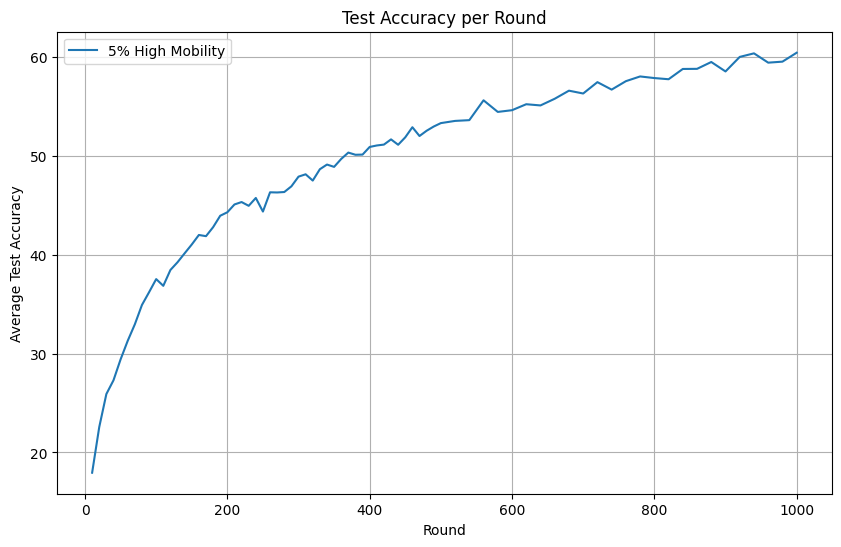

In [109]:
total_averages = inf_dict()

for experiment_group, averages in grouped_averages.items():
    for experiment, _ in averages.items():
        for statistic in statistics:
            for round, value in averages[experiment][statistic].items():
                if round not in total_averages[experiment][statistic]:
                    total_averages[experiment][statistic][round] = []
                total_averages[experiment][statistic][round].append(value)

print(total_averages)

for statistic in statistics:
    for experiment, _ in total_averages.items():
        for round, values in total_averages[experiment][statistic].items():
            total_averages[experiment][statistic][round] = np.mean(values)

plot_high_low_averages(experiments, total_averages, "Total", save_fig=True)

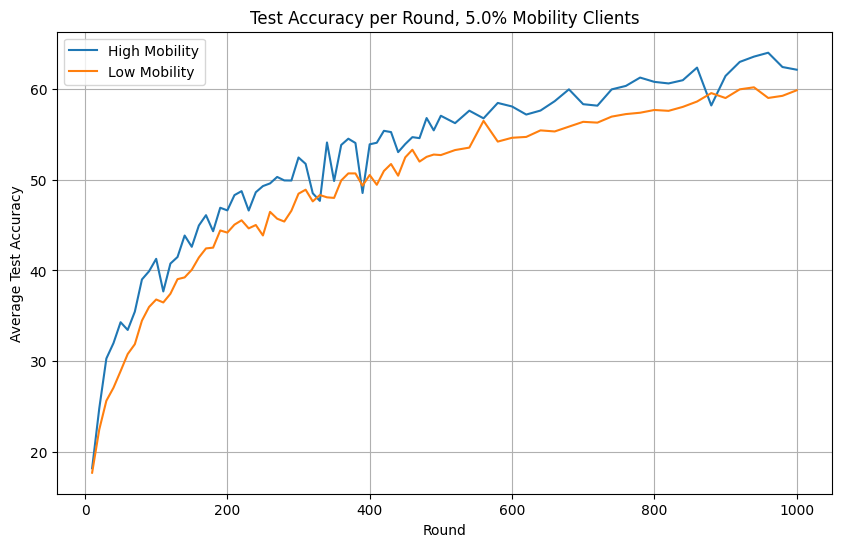

In [110]:
def plot_high_low_averages(high_average, low_average, statistic, mobility_proprtion):
    plt.figure(figsize=(10, 6))


    rounds, acc_values = zip(*high_average[experiment][statistic].items())
    plt.plot(rounds, acc_values, label=f"High Mobility")

    rounds, acc_values = zip(*low_average[experiment][statistic].items())
    plt.plot(rounds, acc_values, label=f"Low Mobility")

    plt.xlabel("Round")
    plt.ylabel("Average Test Accuracy")
    plt.title(f"Test Accuracy per Round, {mobility_proprtion * 100}% Mobility Clients")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"saved_figures/test_accuracy_high_low_{mobility_proprtion}.pdf")
    plt.show()

if len(experiments) != 1:
    raise ValueError("Only one experiment can be plotted at a time")


high_mobility_averages = next(iter(grouped_high_mobility_averages.values()))
low_mobility_averages = next(iter(grouped_low_mobility_averages.values()))
proportion = next(iter(experiments.keys()))
plot_high_low_averages(high_mobility_averages, low_mobility_averages, "test_acc", proportion)